# Generating histograms from power spectrums
In this notebook, all the cells except the last one are used to generate a power spectrum as usual. 
The final cell serves to generate histograms of power values over a range of delays and time. The purpose for this is to evaluate the correlation between data sets at different time. The power spectrum by definition is the visibility squared. If there is gaussian noise present in the visibility with certain mean and standard deviation values, what we obtain is a decreasing slope towards positive x values with a peak at the origin. If we add many of these histograms with one another, we can obtain different log skewed distribution, depending on the number of histograms summed together. This is the definition of the chi squared distribution. However, in the chi squared distribution, the sets of data must be independant from one another. If not, we do not see this increasingly skewed distribution with more data sets combined. Thus, this notebook plots data values from generating squared normal distribution and comparing side by side with the real data.

In [1]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
from scipy.stats import chi2
import random
from scipy.optimize import curve_fit

In [4]:
# select the data file to load
dfile = os.path.join(DATA_PATH, 'zen.2458116.38650.xx.HH.uvOCRS')
# Load into UVData objects
uvd = UVData()
uvd.read(dfile)

In [5]:
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
# if there is no beam file present, then we can create one

#beam_freqs = np.linspace(0, 384e6, 384)
#uvb = hp.PSpecBeamGauss(fwhm=0.2117, beam_freqs=beam_freqs)

In [6]:
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')

# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]

In [7]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
ds.rephase_to_dset(0)
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [8]:
# Specify which baselines to include
baselines = [(120,121)]
# We can cross multiply different baselines or generate the power spectrum for pairs of identical baselines
baselines1, baselines2, blpairs = hp.utils.construct_blpairs(baselines, exclude_auto_bls=True,exclude_permutations=True)
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges=[(400,500),(500,600)], input_data_weight='identity',norm='I', taper='blackman-harris', verbose=True)

# This has been commented out but it can be used instead of the previous line for pairs of different baselines
#uvp = ds.pspec(baselines1, baselines2, (0, 1), [('pI', 'pI')], spw_ranges=[(100,200)], input_data_weight='identity',norm='I', taper='blackman-harris', verbose=True)


Setting spectral range: (400, 500)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((120, 121), (120, 121))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (500, 600)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((120, 121), (120, 121))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


In [9]:
# A chi squared distribution fit for the histograms of power values
def chi_2(x,df,loc,scale): 
    return chi2.pdf(x,df,loc,scale)

Randomly select histograms (0) or index at a time interval (1) :
1
Choose time interval size. This will affect the number of degrees of freedom
as there are a limited amount of time samples.
Total number of time samples is 30.
3


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

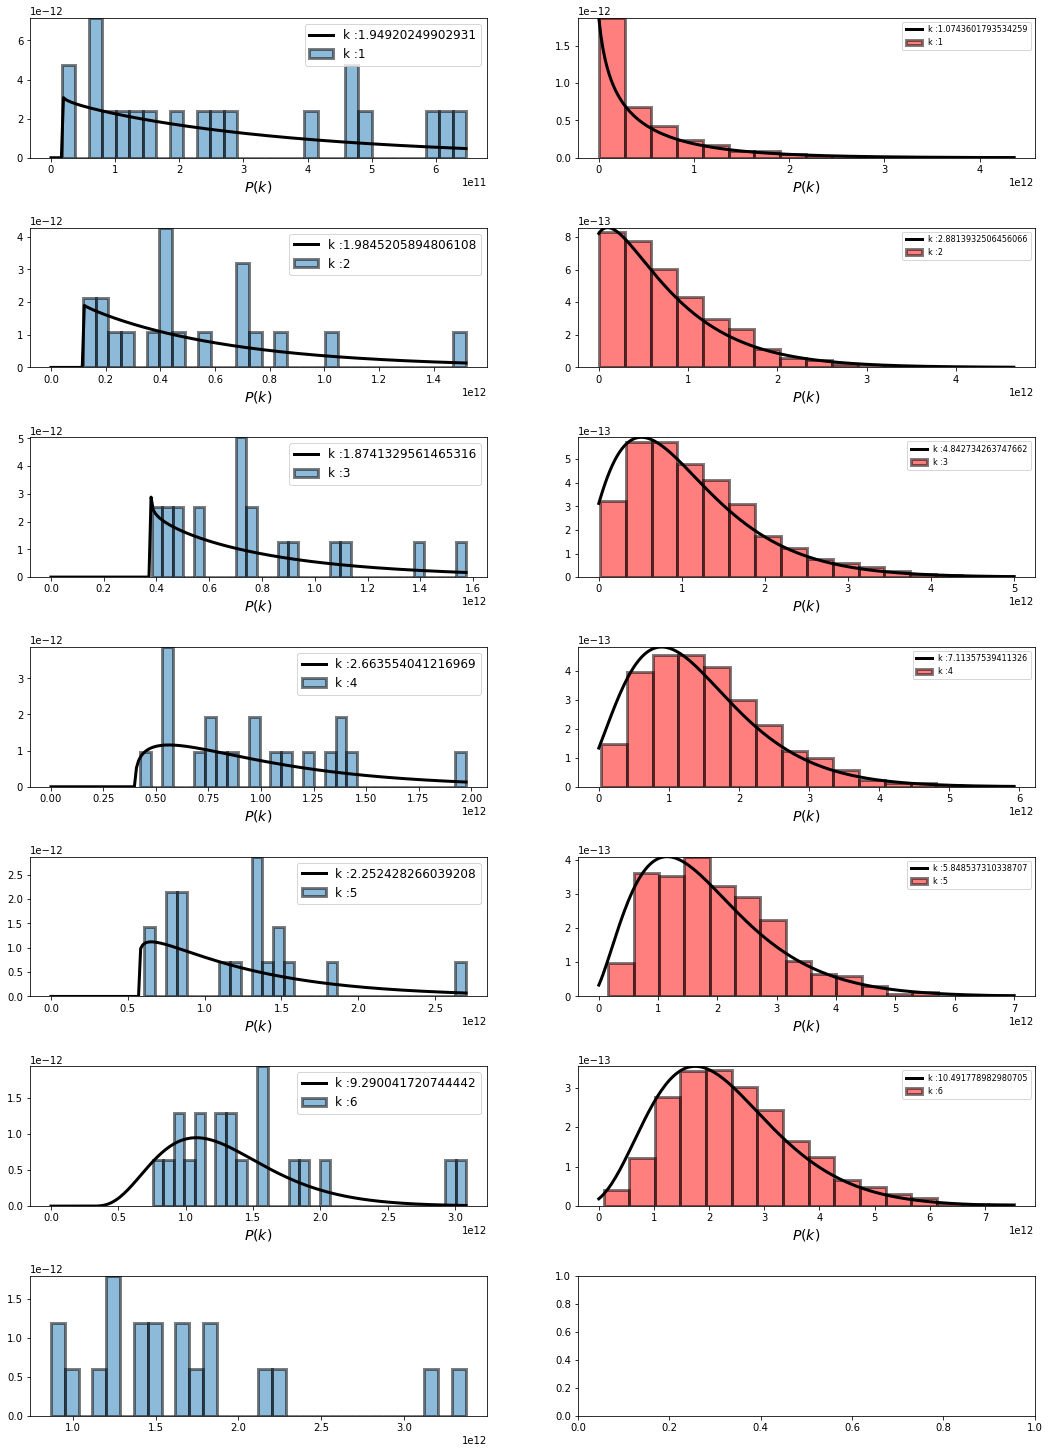

In [19]:
print("Randomly select histograms (0) or index at a time interval (1) :")
choice = int(input())

if choice == 1:
    print("Choose time interval size. This will affect the number of degrees of freedom")
    print("as there are a limited amount of time samples.")
    print("Total number of time samples is " + str(30) + ".")
    interval = int(input())
    # Number of degrees of freedom for the summed histogram (i.e number of histograms summed together)  
    num_df = int(30/interval)

# If the choice wasn't to pick time samples at specific intervals, then the number of degrees of freedom can be modified here
num_df=12
fig = plt.figure(constrained_layout=False)
fig.set_size_inches(w=18,h=45)
gs = gridspec.GridSpec(num_df,1)
gs.update(wspace=0.2, hspace=0.5)

# Specify which baseline and spectral window to plot histograms
spw = 0
blp = uvp.get_blpairs()[0]
key = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9

power = (np.abs(np.real(uvp.get_data(key)))).T

for i in range(1,num_df):
    pwr_norm_sum = 0
    gss01 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[i],wspace=0.2)
    ax1 = fig.add_subplot(gss01[0])
    ax2 = fig.add_subplot(gss01[1])
    df=i
    
    # We pile the data sets of the extremities of the power spectra on top of one another to avoid foregrounds at around 0 delay. 
    # This will allow us to double the number of degrees of freedom
    
    # The first index in power represent the delay range. This must be chosen by the user and modified according
    # to the total number of delay values.
    
    # For example, if the spectral window is (400,800), then there are 400 delay values, and since we know foregrounds
    # are roughly situated halfway thus at 200, then we take values from 0 to roughly 170 and 230 to 400 index wise.
    # The ranges to concatenate the delays must be equal in size.
    # Thus, this means we took all power values at all times except for the ones in the foreground region.
    pwr_folded = np.concatenate((power[0:20,:],power[70:90,:]),axis=1)
    
    if choice == 0:
        # We sum normal distributions with the mean and std values from the real data
        # We can the compare with taking the real data distributions as opposed to normal distributions
        pwr_random = []
        index_random = np.random.randint(pwr_folded.shape[1], size=df)
        
        pwr_random = pwr_folded[:,index_random]
        pwr_random_sum = np.sum(pwr_random,axis=1)
        
        for j in range(0,index_random.shape[0]):
            
            pwr_norm = np.random.normal(np.sqrt(np.mean(pwr_random[:,j])),np.sqrt(np.std(pwr_random[:,j])),500)
            pwr_norm_squared = pwr_norm**2
            pwr_norm_sum = pwr_norm_sum + pwr_norm_squared
        n1, bins1, patches1 = ax1.hist(pwr_random_sum,bins=30,density=True,linewidth=3,edgecolor='k',alpha=0.5,label="k :"+str(df))
        
        # Estimate guesses for the parameters of the chi2 pdf. The guess parameters are the mean and standard deviation of the data
        params1, cov1 = curve_fit(chi_2,bins1[:-1],n1,p0=[5,np.mean(pwr_random_sum),np.std(pwr_random_sum)])
        x1=np.linspace(0,max(pwr_random_sum),200)
        
    # The difference in this choice is that the data are specifically chosen at intervals of time and thus not random.
    if choice == 1:
        for j in range(0,i):
            if j == 0:
                pwr_spread = pwr_folded[:,0:1]
            else:
                pwr_temp = pwr_folded[:,interval*j-1:interval*j]
                pwr_spread = np.concatenate((pwr_spread,pwr_temp),axis=1)
                
        pwr_spread_sum = np.sum(pwr_spread,axis=1)

        for j in range(0,df):

            pwr_norm = np.random.normal(np.sqrt(np.mean(pwr_folded[:,interval*j])),np.sqrt(np.std(pwr_folded[:,interval*j])),1000)
            pwr_norm_squared = pwr_norm**2
            pwr_norm_sum = pwr_norm_sum + pwr_norm_squared
        n1, bins1, patches1 = ax1.hist(pwr_spread_sum,bins=30,density=True,linewidth=3,edgecolor='k',alpha=0.5,label="k :"+str(df))
        params1, cov1 = curve_fit(chi_2,bins1[:-1],n1,p0=[5,np.mean(pwr_spread),np.std(pwr_spread)])
        x1=np.linspace(0,max(pwr_spread_sum),200)

    # The normal distribution histogram is plotted and fitted. The fit results are very sensitive to the guess parameter
    # These conditions are only implemented from multiple tries to fit and seem to work for the most part.
    # There isn't for the moment a definitive way to guess the parameters.
    n2,bins2,patches2 = ax2.hist(pwr_norm_sum,bins=16,density=True,linewidth=3,edgecolor='k',alpha=0.5,color='r',label="k :"+str(df))
    if i >= 6:
        params2, cov2 = curve_fit(chi_2,bins2[:-1],n2,p0=[12,np.mean(pwr_norm_sum),np.std(pwr_norm_sum)])
    else:
        if i ==1:
            params2, cov2 = curve_fit(chi_2,bins2[:-1],n2,p0=[2,np.mean(pwr_norm_sum),np.std(pwr_norm_sum)])
        else:
            params2, cov2 = curve_fit(chi_2,bins2[:-1],n2,p0=[df,np.mean(pwr_norm_sum),np.std(pwr_norm_sum)])
    x2=np.linspace(0,np.max(pwr_norm_sum),200)

    ax1.plot(x1,chi_2(x1,*params1),color='k',lw=3,label="k :"+str(params1[0]))
    ax2.plot(x2,chi_2(x2,*params2),color='k',lw=3,label="k :"+str(params2[0]))
    ax2.set_xlabel(r"$P(k)$", fontsize=14)
    ax1.set_xlabel(r"$P(k)$", fontsize=14)
    ax1.legend(loc=1, prop={'size': 12})
    ax2.legend(loc=1, prop={'size': 8})
    